In [7]:
import torch
mps_device = torch.device("mps")

In [15]:
import pathlib
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
# import keras
from keras import layers
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import AUC
from tensorflow.image import resize

## Load Data and Create Datasets

In [16]:
def load_data():
    # Dataset/hyperparams
    sandbox_dir = pathlib.Path("../Data/Weather_Dataset")
    batch_size = 8
    image_size = (224, 224)  # do not change for resnet50

    # Load dataset
    dataset = tf.keras.utils.image_dataset_from_directory(
        sandbox_dir,
        labels='inferred',
        label_mode='int',
        validation_split=0.2,
        subset="both",
        seed=1234,
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True
    )

    ### USE THESE 
    train_dataset, val_dataset = dataset  

    # === Oversampling Preprocessing for the Training Dataset ===
    # Unbatch the training dataset to work with individual samples
    train_ds_unbatched = train_dataset.unbatch()

    # Retrieve class names and determine number of classes
    class_names = train_dataset.class_names
    num_classes = len(class_names)

    # Create a separate dataset for each class using filtering
    class_datasets = {}
    for i in range(num_classes):
        # Filter out samples that belong to class i
        class_datasets[i] = train_ds_unbatched.filter(lambda image, label: label == i)

    # Count samples per class
    counts = {}
    for i in range(num_classes):
        counts[i] = class_datasets[i].reduce(0, lambda x, _: x + 1).numpy()
    print("Original class counts:", counts)

    # Determine the maximum count among all classes
    max_count = max(counts.values())

    # Oversample each class: repeat and take exactly max_count samples for each
    oversampled_datasets = []
    for i in range(num_classes):
        ds = class_datasets[i].repeat().take(max_count)
        oversampled_datasets.append(ds)

    # Combine the oversampled datasets into one balanced dataset
    balanced_train_ds = oversampled_datasets[0]
    for ds in oversampled_datasets[1:]:
        balanced_train_ds = balanced_train_ds.concatenate(ds)

    # Shuffle and batch the balanced training dataset
    balanced_train_ds = balanced_train_ds.shuffle(buffer_size=1000).batch(batch_size)

    # Optionally, replace train_dataset with the balanced version
    train_dataset = balanced_train_ds

    # === Display a few samples from the balanced training dataset ===
    for images, labels in train_dataset.take(1):
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        for i in range(5):
            axes[i].imshow(images[i].numpy().astype("uint8"))
            axes[i].axis("off")
            axes[i].set_title(f"Label: {labels[i].numpy()}")
        plt.show()
        break

    return train_dataset, val_dataset

In [17]:
def create_datasets(train_dataset, val_dataset):
    # Get X_val and y_val, normalize
    X_train, y_train = [], []
    for images, labels in train_dataset:
        X_train.append((images.numpy() / 255.0))
        y_train.append(labels.numpy())
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    X_val, y_val = [], []
    for images, labels in val_dataset:
        X_val.append((images.numpy() / 255.0))
        y_val.append(labels.numpy())
    X_val = np.concatenate(X_val, axis=0)
    y_val = np.concatenate(y_val, axis=0)

    y_train = y_train.reshape(y_train.shape[0], 1)
    y_val = y_val.reshape(y_val.shape[0], 1)

    return X_train, y_train, X_val, y_val

Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Using 1372 files for validation.


2025-04-12 20:52:01.263320: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 20:52:02.356678: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 20:52:03.652711: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 20:52:05.914654: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 20:52:07.063238: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 20:52:08.693852: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 20:52:10.347724: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 20:52:11.145472: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 20:52:12.072218: W tensorflow/core/lib/png/png_io.cc:89] PNG 

Original class counts: {0: 559, 1: 678, 2: 379, 3: 514, 4: 485, 5: 296, 6: 397, 7: 189, 8: 932, 9: 549, 10: 512}


2025-04-12 20:52:48.808486: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 20:52:49.707600: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 20:52:50.871042: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 20:52:52.573251: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 20:52:53.630995: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


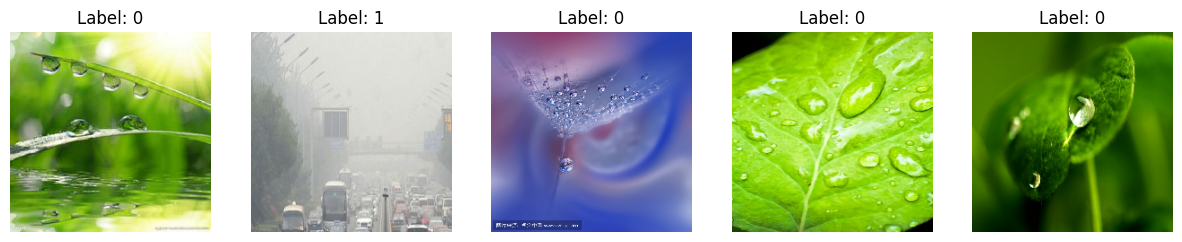

2025-04-12 20:52:56.139882: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 20:52:56.988171: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 20:52:58.124147: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 20:52:59.595076: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 20:53:00.486006: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 20:53:01.959308: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 20:53:02.842181: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 20:53:03.855497: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 20:53:05.681464: W tensorflow/core/lib/png/png_io.cc:89] PNG 

In [5]:
# Load Data and Create Datasets
train_dataset, val_dataset = load_data()
X_train, y_train, X_val, y_val = create_datasets(train_dataset, val_dataset)

In [18]:
# Print the shape of the training dataset
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
# Print the shape of the validation dataset
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
# Print the shape of the first train sample
print(f"X_train[0] shape: {X_train[0].shape}")
print(f"y_train[0] shape: {y_train[0].shape}")

X_train shape: (10252, 224, 224, 3)
y_train shape: (10252, 1)
X_val shape: (1372, 224, 224, 3)
y_val shape: (1372, 1)
X_train[0] shape: (224, 224, 3)
y_train[0] shape: (1,)


## K-Means Color Quantization for 1st image in X_train
https://scikit-learn.org/0.19/auto_examples/cluster/plot_color_quantization.html

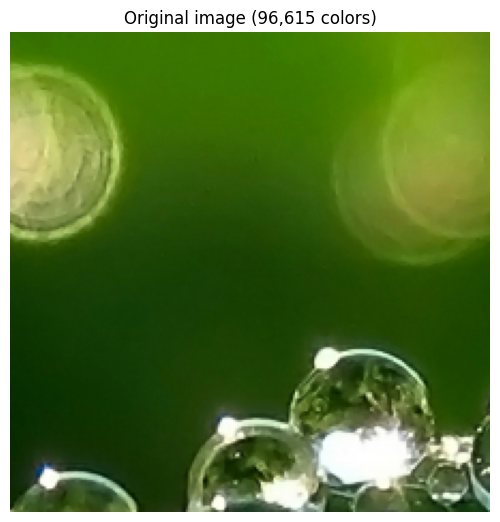

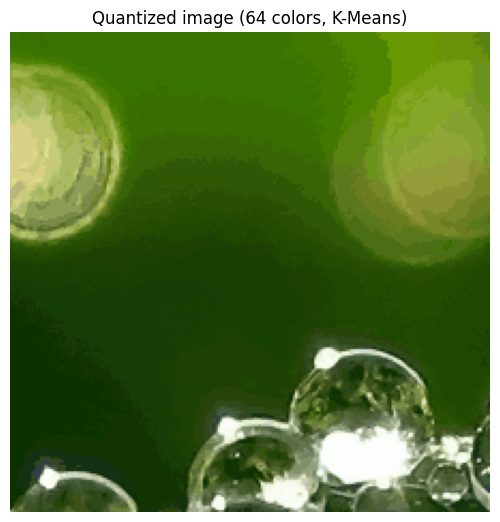

In [19]:
n_colors = 64

image_array = X_train[0].reshape(50176,3)
image_array_sample = shuffle(image_array, random_state=0)[:1000]

kmeans = KMeans(n_clusters=64, random_state=0).fit(image_array_sample)
labels = kmeans.predict(image_array)

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(X_train[0])

plt.figure(2)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (64 colors, K-Means)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, 224, 224))

## K-Means Color Quantization for All Images in X_train

In [20]:
n_colors = 64

X_train_quantized_kmeans = []
for i in range(len(X_train)):
    image_array = X_train[i].reshape(50176,3)
    image_array_sample = shuffle(image_array, random_state=0)[:1000]

    kmeans = KMeans(n_clusters=64, random_state=0).fit(image_array_sample)
    labels = kmeans.predict(image_array)

    def recreate_image(codebook, labels, w, h):
        """Recreate the (compressed) image from the code book & labels"""
        d = codebook.shape[1]
        image = np.zeros((w, h, d))
        label_idx = 0
        for i in range(w):
            for j in range(h):
                image[i][j] = codebook[labels[label_idx]]
                label_idx += 1
        return image
    
    quantized_image = recreate_image(kmeans.cluster_centers_, labels, 224, 224)
    X_train_quantized_kmeans.append(quantized_image)

X_train_quantized_kmeans = np.array(X_train_quantized_kmeans, dtype=np.float32)

## Model Building

In [21]:
import keras
from tensorflow.keras import backend as K
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# # Custom F1-score metric
# def f1_score(y_true, y_pred):
#     y_true = K.cast(y_true, 'float32')  # Cast y_true to float32
#     y_pred = K.round(y_pred)  # Round predictions to 0 or 1
#     tp = K.sum(K.cast(y_true * y_pred, 'float32'), axis=0)  # True positives
#     fp = K.sum(K.cast((1 - y_true) * y_pred, 'float32'), axis=0)  # False positives
#     fn = K.sum(K.cast(y_true * (1 - y_pred), 'float32'), axis=0)  # False negatives

#     precision = tp / (tp + fp + K.epsilon())  # Precision
#     recall = tp / (tp + fn + K.epsilon())  # Recall
#     f1 = 2 * precision * recall / (precision + recall + K.epsilon())  # F1-score
#     return K.mean(f1)  # Return mean F1-score across all classes

# Build Model with Accuracy, AUC, and F1-score metrics
def build_model(X_train, y_train, input_shape): # w/o pca is (224,224,3)

    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)), 
        BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.3),
        
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)), 
        BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),
        # layers.MaxPooling2D(2, 2),
        layers.Dropout(0.3),
        

        layers.Flatten(), # Flatten the output before the dense layer
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(11, activation='softmax')  
    ])
            
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print(model.summary())

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, 1)
    model_history = model.fit(X_train, y_train, epochs=5, validation_split=0.2)

    return model, model_history


def plot_history(model_history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['accuracy'], label='Train Accuracy')
    plt.plot(model_history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Training Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['loss'], label='Train Loss')
    plt.plot(model_history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Training Loss')

    plt.show()
    

def evaluate_model(model, X_val, y_val):
    results = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Loss: {results[0]}")
    print(f"Validation Accuracy: {results[1]}")
    # print(f"Validation AUC: {results[2]}")

    # Get model predictions
    Y_val_pred = model.predict(x=X_val)
    # Get the class with the highest probability for each sample
    Y_val_pred_classes = np.argmax(Y_val_pred, axis=1)

    # Precision, Recall, and F1-Score
    precision = precision_score(y_val, Y_val_pred_classes, average='macro')  # Macro-averaged precision
    recall = recall_score(y_val, Y_val_pred_classes, average='macro')        # Macro-averaged recall
    f1 = f1_score(y_val, Y_val_pred_classes, average='macro')                # Macro-averaged F1-score

    # AUC (One-vs-Rest for multiclass)
    # Convert y_val to one-hot encoding if it's not already
    y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=11)  # Adjust num_classes to your number of classes
    auc = roc_auc_score(y_val_one_hot, Y_val_pred, multi_class='ovr')   # One-vs-Rest AUC

    # Print the metrics
    print(f"Val Precision: {precision}")
    print(f"Val Recall: {recall}")
    print(f"Val F1-Score: {f1}")
    print(f"Val AUC (Avg): {auc}")

    # Print classification report for subgroup accuracies
    print(classification_report(y_val, Y_val_pred_classes, target_names=[str(label) for label in np.unique(y_val)]))
    
    # Get confusion matrix
    conf_matrix=confusion_matrix(y_val, Y_val_pred_classes)
    # Plot confusion matrix
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y_val))
    display.plot()
    plt.title("Validation Dataset Confusion Matrix")
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8, rotation=25)
    plt.show()


In [22]:
# Print the shape of the training dataset
print(f"X_train shape: {X_train_quantized_kmeans.shape}")
print(f"y_train shape: {y_train.shape}")
# Print the shape of the validation dataset
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
# Print the shape of the first train sample
print(f"X_train[0] shape: {X_train_quantized_kmeans[0].shape}")
print(f"y_train[0] shape: {y_train[0].shape}")

X_train shape: (10252, 224, 224, 3)
y_train shape: (10252, 1)
X_val shape: (1372, 224, 224, 3)
y_val shape: (1372, 1)
X_train[0] shape: (224, 224, 3)
y_train[0] shape: (1,)


/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 346112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    44,302,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,398,539 (169.37 MB)

 Trainable params: 44,397,835 (169.36 MB)

 Non-trainable params: 704 (2.75 KB)

None
Epoch 1/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 784s 3s/step - accuracy: 0.5265 - loss: 9.9258 - val_accuracy: 0.0034 - val_loss: 6.7560
Epoch 2/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 742s 3s/step - accuracy: 0.6362 - loss: 3.2908 - val_accuracy: 0.1677 - val_loss: 5.1931
Epoch 3/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 774s 3s/step - accuracy: 0.6604 - loss: 3.1294 - val_accuracy: 0.2267 - val_loss: 5.7503
Epoch 4/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 784s 3s/step - accuracy: 0.6828 - loss: 3.3903 - val_accuracy: 0.3116 - val_loss: 5.9586
Epoch 5/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 742s 3s/step - accuracy: 0.6897 - loss: 3.7823 - val_accuracy: 0.1809 - val_loss: 6.6862


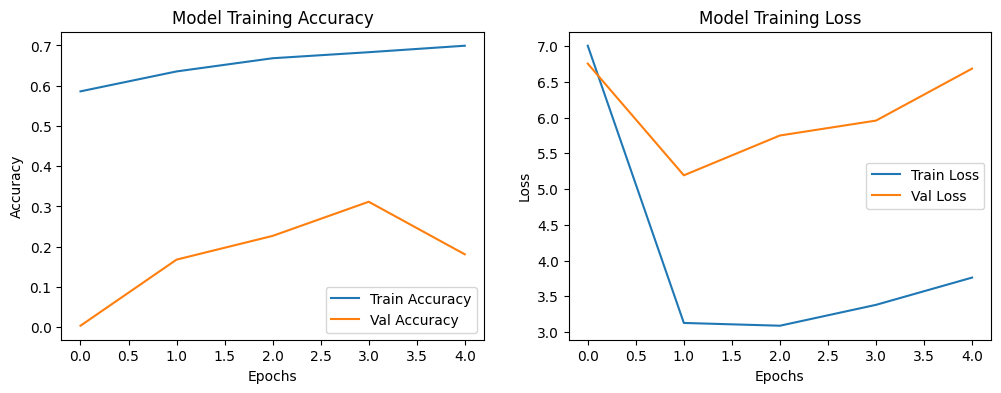

Validation Loss: 4.845664024353027
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 411ms/step


/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Val Precision (Macro): 0.5273053163435327
Val Recall (Macro): 0.4616949422474518
Val F1-Score (Macro): 0.42639789753623164
Val AUC (One-vs-Rest): 0.8733108383997649
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       139
           1       0.63      0.60      0.62       173
           2       0.42      0.52      0.47        96
           3       0.36      0.58      0.44       125
           4       0.82      0.13      0.23       106
           5       0.19      0.96      0.32        81
           6       0.61      0.54      0.57       129
           7       0.30      0.19      0.23        43
           8       0.74      0.39      0.52       228
           9       0.98      0.36      0.53       143
          10       0.00      0.00      0.00       109

    accuracy                           0.47      1372
   macro avg       0.53      0.46      0.43      1372
weighted avg       0.58      0.47      0.47      1372



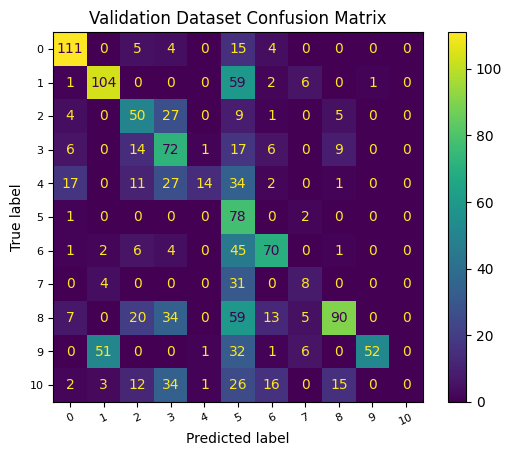

In [23]:
X_train_quantized_kmeans = tf.convert_to_tensor(X_train_quantized_kmeans, dtype=tf.float32)
# y_train = y_train.flatten()
# y_val = y_val.flatten()
kmeans_model, kmeans_model_history = build_model(X_train_quantized_kmeans, y_train, (224,224,3))

plot_history(kmeans_model_history)

evaluate_model(kmeans_model, X_val, y_val)

In [26]:
results = kmeans_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {results[0]}")
print(f"Validation Accuracy: {results[1]}")

Validation Loss: 4.845664024353027
Validation Accuracy: 0.47303205728530884


## PCA on X_train

In [27]:
def pca(X_train_flat, X_val):
    # Create instance of PCA and fit
    pca = PCA()
    pca.fit_transform(X_train_flat)

    # Find cumulative variance
    var_cum = np.cumsum(pca.explained_variance_ratio_) * 100

    # How many principal components explain 95% of the variance?
    k = np.argmax(var_cum > 95) + 1  # +1 because np.argmax returns the first index where condition is met
    print("Number of principal components explaining 95% of variance: " + str(k))

    # Plot cumulative variance
    plt.figure(figsize=[5, 4])
    plt.title('Cumulative variance explained by the components')
    plt.ylabel('Explained variance')
    plt.xlabel('Principal components')
    plt.axvline(x=k, color="k", linestyle="--", label=f"K={k}")
    plt.axhline(y=95, color="r", linestyle="--", label="95% of cumulative variance")
    plt.plot(var_cum)
    plt.legend()
    plt.show()


def pca_fit(X_train_flat, X_val_flat, n_components, image_shape):
    # re run PCA using chosen k = 972 for compatability with vgg16 (18 x 18 = 324 * 3 = 972)
    pca = PCA(n_components=n_components) 
    X_train_pca = pca.fit_transform(X_train_flat)
    X_val_pca = pca.transform(X_val_flat)

    # Get principal components
    principal_Df = pd.DataFrame(data = X_train_pca,)
    principal_Df['Label'] = y_train
    print(principal_Df.head())

    # Variance of principal components
    print('Explained Variation per Principal Component: {}'.format(pca.explained_variance_ratio_))

    print(f"Before PCA X_train.shape: {X_train_flat.shape}")
    print(f"After PCA X_train.shape: {X_train_pca.shape}")

    # Reshape images to (18,18) since 18*18= 324*3 = 972 (number of principal components/features)
    img_rows, img_cols= image_shape

    X_train_pca = X_train_pca.reshape(X_train_pca.shape[0], img_rows, img_cols, 3) 
    X_val_pca = X_val_pca.reshape(X_val.shape[0], img_rows, img_cols, 3) 

    print(f"After PCA X_train reshaped: {X_train_pca.shape}")
    print(f"y_train: {y_train.shape}")

    return pca, X_train_pca

In [ ]:
# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)  
X_val_flat = X_val.reshape(X_val.shape[0], -1)  

pca(X_train_flat, X_val_flat)

In [82]:
# re run PCA using chosen k = 972 for compatability with vgg16 (18 x 18 = 324 * 3 = 972)
pca, X_train_pca = pca_fit(X_train_flat, n_components=__, image_size = (___, __))

KeyboardInterrupt: 

In [ ]:
pca_model, pca_model_history = build_model(X_train_pca, y_train, (__,__,3))
plot_history(pca_model_history)
evaluate_model(pca_model, X_val, y_val)

## PCA on X_train_quantized_kmeans

In [ ]:
# Flatten the images
X_train_quantized_kmeans_flat = X_train_quantized_kmeans.reshape(X_train_quantized_kmeans.shape[0], -1)  

pca(X_train_quantized_kmeans_flat)

In [ ]:
# re run PCA using chosen k = 972 for compatability with vgg16 (18 x 18 = 324 * 3 = 972)
pca, X_train_quantized_kmeans_pca = pca_fit(X_train_quantized_kmeans_flat, n_components=__, image_size = (___, __))

In [ ]:
kmeans_pca_model, kmeans_pca_model_history = build_model(X_train_quantized_kmeans_pca, y_train, (20,20,3))
plot_history(kmeans_pca_model_history)
evaluate_model(kmeans_pca_model, X_val, y_val)